In [2]:

import os
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from monai.transforms import (
    Compose, LoadImage, Resize, ScaleIntensity, ToTensor
)
from monai.networks.nets import UNet, AutoEncoder
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

from tqdm import tqdm


In [3]:
DATA_ROOT = "./data"
SLICE_RANGE = [145, 291]

CHANNELS = (16, 32, 64, 128, 256)
STRIDES = (2, 2, 2, 2,2)

IMG_SIZE = (256,256)

NBR_EPOCH_ENCODEUR = 30
NBR_EPOCH_UNET = 50


## Selection des patients

In [4]:

from sklearn.model_selection import train_test_split

all_patients = sorted(os.listdir(DATA_ROOT))
random.seed(42)
random.shuffle(all_patients)

test_patients = all_patients[:1]
supervised_pool = all_patients[9:]

# Split supervised patients into train and val
train_patients, val_patients = train_test_split(supervised_pool, test_size=0.25, random_state=42)

unsupervised_patients = all_patients

print(f"Test: {test_patients}")
print(f"Train: {train_patients}")
print(f"Validation: {val_patients}")
print(f"Unsupervised: {unsupervised_patients}")


Test: ['07040DORE']
Train: ['08002CHJE', '08027SYBR', '01038PAGU', '01016SACH']
Validation: ['01040VANE', '01042GULE']
Unsupervised: ['07040DORE', '08031SEVE', '07010NABO', '07003SATH', '08037ROGU', '08029IVDI', '07001MOEL', '01039VITE', '07043SEME', '01040VANE', '01042GULE', '08027SYBR', '01016SACH', '01038PAGU', '08002CHJE']


## Proportion Masque vide par patient

In [5]:
def analyse_masques_vides_par_patient(dataset, indices=None):
    from collections import defaultdict

    vide_par_patient = defaultdict(lambda: {"total": 0, "vides": 0})

    if indices is None:
        indices = range(len(dataset))

    for idx in indices:
        if isinstance(dataset, torch.utils.data.Subset):
            vrai_idx = dataset.indices[idx]
            patient = dataset.dataset.get_patient_name(vrai_idx)
            _, mask, _ = dataset.dataset[vrai_idx]
        else:
            patient = dataset.get_patient_name(idx)
            _, mask, _ = dataset[idx]

        vide_par_patient[patient]["total"] += 1
        if mask.sum().item() == 0:
            vide_par_patient[patient]["vides"] += 1

    print(f"{'Patient':<15}{'Slices vides':<15}{'Total slices':<15}{'Proportion vide'}")
    print("-" * 60)
    for patient, stats in sorted(vide_par_patient.items()):
        total = stats["total"]
        vides = stats["vides"]
        proportion = vides / total if total > 0 else 0
        print(f"{patient:<15}{vides:<15}{total:<15}{proportion:.2%}")

## DataSet

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    """
    Dataset PyTorch pour charger des paires image/masque depuis des dossiers de slices PNG.
    Gère les cas avec ou sans masque (pré-entraînement ou entraînement supervisé).
    Prend en compte une liste explicite de patients.
    """
    def __init__(self, root_dir, with_mask=True, resized_size=(256, 256), slice_range=None, transform=None, patient_list=None):
        self.image_paths = []
        self.mask_paths = []
        self.patient_names = []
        self.resized_size = resized_size
        self.slice_range = slice_range
        self.with_mask = with_mask
        self.transform = transform if transform is not None else transforms.ToTensor()

        # Filtrer les patients selon la liste fournie
        all_patients = sorted(os.listdir(root_dir))
        patients = patient_list if patient_list is not None else all_patients

        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder):
                continue
            if self.with_mask and not os.path.isdir(masks_folder):
                continue

            for img_file in sorted(os.listdir(images_folder)):
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue

                slice_num = int(match.group(1))
                if self.slice_range and not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                    continue

                img_path = os.path.join(images_folder, img_file)
                if self.with_mask:
                    mask_path = os.path.join(masks_folder, img_file)
                    if not os.path.exists(mask_path):
                        continue
                    self.mask_paths.append(mask_path)

                self.image_paths.append(img_path)
                self.patient_names.append(patient)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        resize = transforms.Resize(self.resized_size)
        img = resize(img)
        img = self.transform(img)
        img = (img - 0.5) / 0.5  # Normalisation [-1, 1]

        if self.with_mask:
            mask = Image.open(self.mask_paths[idx]).convert('L')
            mask = resize(mask)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()
            return img, mask, self.image_paths[idx]
        else:
            return img, self.image_paths[idx]

    def get_patient_name(self, idx):
        return self.patient_names[idx]


## DataLoader

In [7]:

# Création des datasets
unsup_dataset = PngSlicesDataset(DATA_ROOT, with_mask=False, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=unsupervised_patients)
train_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=train_patients)
val_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=val_patients)
test_dataset = PngSlicesDataset(DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE, patient_list=test_patients)


In [8]:
import matplotlib.pyplot as plt

def afficher_batch(loader, titre, with_mask):
    batch = next(iter(loader))

    if with_mask:
        imgs, masks, paths = batch
        masks = masks[:4].cpu()
    else:
        imgs, paths = batch
        masks = [None] * 4

    imgs = imgs[:4].cpu()

    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 4))
    fig.suptitle(titre, fontsize=16)

    for i, (img, mask) in enumerate(zip(imgs, masks)):
        img_np = img.squeeze().numpy()

        if mask is not None:
            mask_np = mask.squeeze().numpy()
            combined = img_np * 0.6 + mask_np * 0.4
            axes[i].imshow(combined, cmap='gray')
            axes[i].set_title("Avec masque")
        else:
            axes[i].imshow(img_np, cmap='gray')
            axes[i].set_title("Image seule")

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


#afficher_batch(unsup_dataset, "Images Non Annotées (unsup_loader)", with_mask=False)
#afficher_batch(train_dataset, "Images Annotées (train_loader)", with_mask=True)
#afficher_batch(test_dataset, "Images de Test (test_loader)", with_mask=True)

## Entrainement Auto Encodeur MONAI

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



=== Epoch 1/30 ===


Train batches: 100%|██████████| 215/215 [01:08<00:00,  3.15it/s]


Train Loss: 0.2347


Val batches: 100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


 Val  Loss: 0.0561
💾 Meilleur modèle sauvegardé (0.0561)

=== Epoch 2/30 ===


Train batches: 100%|██████████| 215/215 [00:43<00:00,  4.90it/s]


Train Loss: 0.0571


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.31it/s]


 Val  Loss: 0.0490
💾 Meilleur modèle sauvegardé (0.0490)

=== Epoch 3/30 ===


Train batches: 100%|██████████| 215/215 [00:43<00:00,  4.93it/s]


Train Loss: 0.0511


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]


 Val  Loss: 0.0455
💾 Meilleur modèle sauvegardé (0.0455)

=== Epoch 4/30 ===


Train batches: 100%|██████████| 215/215 [00:44<00:00,  4.84it/s]


Train Loss: 0.0461


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.43it/s]


 Val  Loss: 0.0402
💾 Meilleur modèle sauvegardé (0.0402)

=== Epoch 5/30 ===


Train batches: 100%|██████████| 215/215 [00:42<00:00,  5.10it/s]


Train Loss: 0.0396


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.57it/s]


 Val  Loss: 0.0366
💾 Meilleur modèle sauvegardé (0.0366)

=== Epoch 6/30 ===


Train batches: 100%|██████████| 215/215 [00:42<00:00,  5.02it/s]


Train Loss: 0.0345


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.63it/s]


 Val  Loss: 0.0315
💾 Meilleur modèle sauvegardé (0.0315)

=== Epoch 7/30 ===


Train batches: 100%|██████████| 215/215 [00:30<00:00,  7.17it/s]


Train Loss: 0.0303


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.39it/s]


 Val  Loss: 0.0279
💾 Meilleur modèle sauvegardé (0.0279)

=== Epoch 8/30 ===


Train batches: 100%|██████████| 215/215 [00:23<00:00,  9.14it/s]


Train Loss: 0.0265


Val batches: 100%|██████████| 22/22 [00:02<00:00,  7.62it/s]


 Val  Loss: 0.0253
💾 Meilleur modèle sauvegardé (0.0253)

=== Epoch 9/30 ===


Train batches: 100%|██████████| 215/215 [00:45<00:00,  4.75it/s]


Train Loss: 0.0232


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


 Val  Loss: 0.0226
💾 Meilleur modèle sauvegardé (0.0226)

=== Epoch 10/30 ===


Train batches: 100%|██████████| 215/215 [00:23<00:00,  9.06it/s]


Train Loss: 0.0206


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.94it/s]


 Val  Loss: 0.0204
💾 Meilleur modèle sauvegardé (0.0204)

=== Epoch 11/30 ===


Train batches: 100%|██████████| 215/215 [00:23<00:00,  9.02it/s]


Train Loss: 0.0184


Val batches: 100%|██████████| 22/22 [00:03<00:00,  7.04it/s]


 Val  Loss: 0.0194
💾 Meilleur modèle sauvegardé (0.0194)

=== Epoch 12/30 ===


Train batches: 100%|██████████| 215/215 [00:28<00:00,  7.44it/s]


Train Loss: 0.0168


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]


 Val  Loss: 0.0175
💾 Meilleur modèle sauvegardé (0.0175)

=== Epoch 13/30 ===


Train batches: 100%|██████████| 215/215 [00:48<00:00,  4.43it/s]


Train Loss: 0.0151


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]


 Val  Loss: 0.0165
💾 Meilleur modèle sauvegardé (0.0165)

=== Epoch 14/30 ===


Train batches: 100%|██████████| 215/215 [00:54<00:00,  3.98it/s]


Train Loss: 0.0141


Val batches: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]


 Val  Loss: 0.0152
💾 Meilleur modèle sauvegardé (0.0152)

=== Epoch 15/30 ===


Train batches: 100%|██████████| 215/215 [00:53<00:00,  3.99it/s]


Train Loss: 0.0128


Val batches: 100%|██████████| 22/22 [00:06<00:00,  3.59it/s]


 Val  Loss: 0.0145
💾 Meilleur modèle sauvegardé (0.0145)

=== Epoch 16/30 ===


Train batches: 100%|██████████| 215/215 [00:29<00:00,  7.22it/s]


Train Loss: 0.0122


Val batches: 100%|██████████| 22/22 [00:02<00:00,  7.97it/s]


 Val  Loss: 0.0146

=== Epoch 17/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.25it/s]


Train Loss: 0.0113


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.36it/s]


 Val  Loss: 0.0129
💾 Meilleur modèle sauvegardé (0.0129)

=== Epoch 18/30 ===


Train batches: 100%|██████████| 215/215 [00:27<00:00,  7.77it/s]


Train Loss: 0.0109


Val batches: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


 Val  Loss: 0.0129
💾 Meilleur modèle sauvegardé (0.0129)

=== Epoch 19/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.20it/s]


Train Loss: 0.0100


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.79it/s]


 Val  Loss: 0.0119
💾 Meilleur modèle sauvegardé (0.0119)

=== Epoch 20/30 ===


Train batches: 100%|██████████| 215/215 [00:27<00:00,  7.91it/s]


Train Loss: 0.0094


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.99it/s]


 Val  Loss: 0.0137

=== Epoch 21/30 ===


Train batches: 100%|██████████| 215/215 [00:25<00:00,  8.52it/s]


Train Loss: 0.0089


Val batches: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


 Val  Loss: 0.0115
💾 Meilleur modèle sauvegardé (0.0115)

=== Epoch 22/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.21it/s]


Train Loss: 0.0086


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]


 Val  Loss: 0.0119

=== Epoch 23/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.25it/s]


Train Loss: 0.0078


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.89it/s]


 Val  Loss: 0.0100
💾 Meilleur modèle sauvegardé (0.0100)

=== Epoch 24/30 ===


Train batches: 100%|██████████| 215/215 [00:27<00:00,  7.89it/s]


Train Loss: 0.0075


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.62it/s]


 Val  Loss: 0.0096
💾 Meilleur modèle sauvegardé (0.0096)

=== Epoch 25/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  7.99it/s]


Train Loss: 0.0069


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.45it/s]


 Val  Loss: 0.0095
💾 Meilleur modèle sauvegardé (0.0095)

=== Epoch 26/30 ===


Train batches: 100%|██████████| 215/215 [00:27<00:00,  7.85it/s]


Train Loss: 0.0067


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


 Val  Loss: 0.0089
💾 Meilleur modèle sauvegardé (0.0089)

=== Epoch 27/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.21it/s]


Train Loss: 0.0062


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.25it/s]


 Val  Loss: 0.0086
💾 Meilleur modèle sauvegardé (0.0086)

=== Epoch 28/30 ===


Train batches: 100%|██████████| 215/215 [00:26<00:00,  8.25it/s]


Train Loss: 0.0059


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


 Val  Loss: 0.0084
💾 Meilleur modèle sauvegardé (0.0084)

=== Epoch 29/30 ===


Train batches: 100%|██████████| 215/215 [00:24<00:00,  8.68it/s]


Train Loss: 0.0057


Val batches: 100%|██████████| 22/22 [00:02<00:00,  7.76it/s]


 Val  Loss: 0.0084

=== Epoch 30/30 ===


Train batches: 100%|██████████| 215/215 [00:24<00:00,  8.77it/s]


Train Loss: 0.0053


Val batches: 100%|██████████| 22/22 [00:03<00:00,  6.87it/s]


 Val  Loss: 0.0086


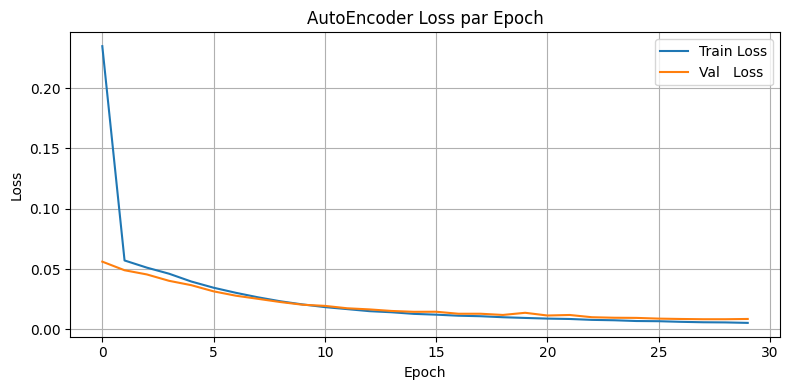

In [ ]:
# =========================
# 1) Auto-encodeur
# =========================
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.networks.nets import AutoEncoder
from monai.losses import SSIMLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyper-paramètres
BATCH_AE    = 8
NUM_WORKERS = 0
N_EPOCH_AE  = 30
LR_AE       = 1e-3
PATIENCE_AE = 8
MODEL_DIR   = "./checkpoints"
os.makedirs(MODEL_DIR, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoaders
unsup_loader = DataLoader(
    unsup_dataset, batch_size=BATCH_AE,
    shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
val_loader_ae = DataLoader(
    val_dataset, batch_size=BATCH_AE,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

# Modèle
ae = AutoEncoder(
    spatial_dims=2, in_channels=1, out_channels=1,
    channels=CHANNELS, strides=STRIDES
).to(DEVICE)

# Loss & optim
mse  = nn.MSELoss()
ssim = SSIMLoss(spatial_dims=2, data_range=1.0)
opt_ae = torch.optim.AdamW(ae.parameters(), lr=LR_AE, weight_decay=1e-5)
sched_ae = ReduceLROnPlateau(opt_ae, mode="min", patience=4, factor=0.5, verbose=True)

# Entraînement
best_val, es = float("inf"), 0
train_losses, val_losses = [], []

for epoch in range(1, N_EPOCH_AE+1):
    ae.train()
    rt = 0.0
    for imgs, *_ in tqdm(unsup_loader, desc=f"AE Train {epoch}"):
        imgs = imgs.to(DEVICE)
        recon = ae(imgs)
        l_m = mse(recon, imgs)
        l_s = 1 - ssim(recon, imgs)
        loss = l_m + 0.2 * l_s
        opt_ae.zero_grad(); loss.backward(); opt_ae.step()
        rt += loss.item()
    train_losses.append(rt/len(unsup_loader))

    # Validation
    ae.eval()
    rv = 0.0
    with torch.no_grad():
        for imgs, *_ in val_loader_ae:
            imgs = imgs.to(DEVICE)
            recon = ae(imgs)
            l_m = mse(recon, imgs)
            l_s = 1 - ssim(recon, imgs)
            rv += (l_m + 0.2*l_s).item()
    val_losses.append(rv/len(val_loader_ae))

    sched_ae.step(val_losses[-1])
    if val_losses[-1] < best_val:
        best_val, es = val_losses[-1], 0
        torch.save(ae.state_dict(), os.path.join(MODEL_DIR, "best_ae.pth"))
    else:
        es += 1
        if es >= PATIENCE_AE:
            print("⏹ Early stopping AE"); break

# Courbes AE
plt.figure(figsize=(6,3))
plt.plot(train_losses, label="Train AE")
plt.plot(val_losses,   label="Val AE")
plt.legend(); plt.title("AutoEncoder Loss"); plt.show()


## UNet

In [ ]:
# =========================
# 2) Transfert de l’encodeur
# =========================
import torch
from monai.networks.nets import UNet

# Initialisation du UNet
unet = UNet(
    spatial_dims=2, in_channels=1, out_channels=1,
    channels=CHANNELS, strides=STRIDES, num_res_units=1
).to(DEVICE)

# Charger l’AE et copier couche à couche
ae.load_state_dict(torch.load(os.path.join(MODEL_DIR, "best_ae.pth")))
ae.eval()
with torch.no_grad():
    # Niveau 0
    unet.model[0].conv.unit0.conv.weight.copy_(ae.encode.encode_0.conv.weight)
    unet.model[0].conv.unit0.conv.bias.copy_(ae.encode.encode_0.conv.bias)
    unet.model[0].conv.unit0.adn.A.weight.copy_(ae.encode.encode_0.adn.A.weight)
    # Niveau 1
    lvl1 = unet.model[1].submodule[0].conv.unit0
    lvl1.conv.weight.copy_(ae.encode.encode_1.conv.weight)
    lvl1.conv.bias.copy_(ae.encode.encode_1.conv.bias)
    lvl1.adn.A.weight.copy_(ae.encode.encode_1.adn.A.weight)
    # Niveau 2
    lvl2 = unet.model[1].submodule[1].submodule[0].conv.unit0
    lvl2.conv.weight.copy_(ae.encode.encode_2.conv.weight)
    lvl2.conv.bias.copy_(ae.encode.encode_2.conv.bias)
    lvl2.adn.A.weight.copy_(ae.encode.encode_2.adn.A.weight)
    # Niveau 3
    lvl3 = unet.model[1].submodule[1].submodule[1].submodule[0].conv.unit0
    lvl3.conv.weight.copy_(ae.encode.encode_3.conv.weight)
    lvl3.conv.bias.copy_(ae.encode.encode_3.conv.bias)
    lvl3.adn.A.weight.copy_(ae.encode.encode_3.adn.A.weight)
    # Niveau 4
    lvl4 = unet.model[1].submodule[1].submodule[1].submodule[1].submodule
    lvl4.conv.unit0.conv.weight.copy_(ae.encode.encode_4.conv.weight)
    lvl4.conv.unit0.conv.bias.copy_(ae.encode.encode_4.conv.bias)
    lvl4.conv.unit0.adn.A.weight.copy_(ae.encode.encode_4.adn.A.weight)

print("✅ Transfert des poids terminé.")


---- AutoEncoder encode keys: ----
encode_0.conv.weight torch.Size([16, 1, 3, 3])
encode_0.conv.bias torch.Size([16])
encode_0.adn.A.weight torch.Size([1])
encode_1.conv.weight torch.Size([32, 16, 3, 3])
encode_1.conv.bias torch.Size([32])
encode_1.adn.A.weight torch.Size([1])
encode_2.conv.weight torch.Size([64, 32, 3, 3])
encode_2.conv.bias torch.Size([64])
encode_2.adn.A.weight torch.Size([1])
encode_3.conv.weight torch.Size([128, 64, 3, 3])
encode_3.conv.bias torch.Size([128])
encode_3.adn.A.weight torch.Size([1])
encode_4.conv.weight torch.Size([256, 128, 3, 3])
encode_4.conv.bias torch.Size([256])
encode_4.adn.A.weight torch.Size([1])

---- UNet state_dict keys: ----
model.0.conv.unit0.conv.weight torch.Size([16, 1, 3, 3])
model.0.conv.unit0.conv.bias torch.Size([16])
model.0.conv.unit0.adn.A.weight torch.Size([1])
model.0.residual.weight torch.Size([16, 1, 3, 3])
model.0.residual.bias torch.Size([16])
model.1.submodule.0.conv.unit0.conv.weight torch.Size([32, 16, 3, 3])
model.1.

`len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.


## Fine-tunning


🔎 Train dataset : 495 slices
🔎 Val dataset   : 171 slices

🚀 Epoch 1/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.46it/s]


[✓] Train Loss: 0.9068


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.72it/s]


🔍 Val Loss: 0.8916, Dice: 0.0698
💾 Saved best model (val_loss = 0.8916)

🚀 Epoch 2/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.55it/s]


[✓] Train Loss: 0.8796


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.82it/s]


🔍 Val Loss: 0.8801, Dice: 0.1053
💾 Saved best model (val_loss = 0.8801)

🚀 Epoch 3/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.63it/s]


[✓] Train Loss: 0.8686


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  7.28it/s]


🔍 Val Loss: 0.8733, Dice: 0.1418
💾 Saved best model (val_loss = 0.8733)

🚀 Epoch 4/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.74it/s]


[✓] Train Loss: 0.8621


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.53it/s]


🔍 Val Loss: 0.8673, Dice: 0.1454
💾 Saved best model (val_loss = 0.8673)

🚀 Epoch 5/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.71it/s]


[✓] Train Loss: 0.8559


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]


🔍 Val Loss: 0.8640, Dice: 0.1700
💾 Saved best model (val_loss = 0.8640)

🚀 Epoch 6/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 12.23it/s]


[✓] Train Loss: 0.8508


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.85it/s]


🔍 Val Loss: 0.8603, Dice: 0.1728
💾 Saved best model (val_loss = 0.8603)

🚀 Epoch 7/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.44it/s]


[✓] Train Loss: 0.8469


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.80it/s]


🔍 Val Loss: 0.8583, Dice: 0.1932
💾 Saved best model (val_loss = 0.8583)

🚀 Epoch 8/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 12.06it/s]


[✓] Train Loss: 0.8434


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]


🔍 Val Loss: 0.8563, Dice: 0.2013
💾 Saved best model (val_loss = 0.8563)

🚀 Epoch 9/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 12.13it/s]


[✓] Train Loss: 0.8405


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.19it/s]


🔍 Val Loss: 0.8546, Dice: 0.2086
💾 Saved best model (val_loss = 0.8546)

🚀 Epoch 10/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.60it/s]


[✓] Train Loss: 0.8378


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.61it/s]


🔍 Val Loss: 0.8540, Dice: 0.2100
💾 Saved best model (val_loss = 0.8540)

🚀 Epoch 11/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.85it/s]


[✓] Train Loss: 0.8352


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.05it/s]


🔍 Val Loss: 0.8537, Dice: 0.2098
💾 Saved best model (val_loss = 0.8537)

🚀 Epoch 12/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 12.05it/s]


[✓] Train Loss: 0.8328


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.89it/s]


🔍 Val Loss: 0.8519, Dice: 0.2230
💾 Saved best model (val_loss = 0.8519)

🚀 Epoch 13/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.85it/s]


[✓] Train Loss: 0.8305


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.46it/s]


🔍 Val Loss: 0.8482, Dice: 0.2493
💾 Saved best model (val_loss = 0.8482)

🚀 Epoch 14/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.58it/s]


[✓] Train Loss: 0.8282


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.15it/s]


🔍 Val Loss: 0.8471, Dice: 0.2430
💾 Saved best model (val_loss = 0.8471)

🚀 Epoch 15/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.57it/s]


[✓] Train Loss: 0.8262


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


🔍 Val Loss: 0.8469, Dice: 0.2475
💾 Saved best model (val_loss = 0.8469)

🚀 Epoch 16/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.88it/s]


[✓] Train Loss: 0.8240


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  7.17it/s]


🔍 Val Loss: 0.8463, Dice: 0.2658
💾 Saved best model (val_loss = 0.8463)

🚀 Epoch 17/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.89it/s]


[✓] Train Loss: 0.8219


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.28it/s]


🔍 Val Loss: 0.8438, Dice: 0.2623
💾 Saved best model (val_loss = 0.8438)

🚀 Epoch 18/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 12.34it/s]


[✓] Train Loss: 0.8201


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s]


🔍 Val Loss: 0.8445, Dice: 0.2574

🚀 Epoch 19/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.33it/s]


[✓] Train Loss: 0.8182


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


🔍 Val Loss: 0.8407, Dice: 0.2747
💾 Saved best model (val_loss = 0.8407)

🚀 Epoch 20/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 13.37it/s]


[✓] Train Loss: 0.8162


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.95it/s]


🔍 Val Loss: 0.8394, Dice: 0.2665
💾 Saved best model (val_loss = 0.8394)

🚀 Epoch 21/50


Train Batches: 100%|██████████| 124/124 [00:12<00:00, 10.14it/s]


[✓] Train Loss: 0.8144


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


🔍 Val Loss: 0.8396, Dice: 0.2732

🚀 Epoch 22/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.86it/s]


[✓] Train Loss: 0.8126


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s]


🔍 Val Loss: 0.8411, Dice: 0.2550

🚀 Epoch 23/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 11.20it/s]


[✓] Train Loss: 0.8108


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.56it/s]


🔍 Val Loss: 0.8392, Dice: 0.2660
💾 Saved best model (val_loss = 0.8392)

🚀 Epoch 24/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.84it/s]


[✓] Train Loss: 0.8091


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.75it/s]


🔍 Val Loss: 0.8373, Dice: 0.2927
💾 Saved best model (val_loss = 0.8373)

🚀 Epoch 25/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.46it/s]


[✓] Train Loss: 0.8073


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


🔍 Val Loss: 0.8379, Dice: 0.2784

🚀 Epoch 26/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.29it/s]


[✓] Train Loss: 0.8055


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.95it/s]


🔍 Val Loss: 0.8361, Dice: 0.2814
💾 Saved best model (val_loss = 0.8361)

🚀 Epoch 27/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.89it/s]


[✓] Train Loss: 0.8039


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.03it/s]


🔍 Val Loss: 0.8380, Dice: 0.2781

🚀 Epoch 28/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 11.16it/s]


[✓] Train Loss: 0.8024


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  7.15it/s]


🔍 Val Loss: 0.8353, Dice: 0.2947
💾 Saved best model (val_loss = 0.8353)

🚀 Epoch 29/50


Train Batches: 100%|██████████| 124/124 [00:12<00:00,  9.96it/s]


[✓] Train Loss: 0.8006


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.59it/s]


🔍 Val Loss: 0.8350, Dice: 0.2717
💾 Saved best model (val_loss = 0.8350)

🚀 Epoch 30/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.62it/s]


[✓] Train Loss: 0.7988


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.64it/s]


🔍 Val Loss: 0.8322, Dice: 0.2870
💾 Saved best model (val_loss = 0.8322)

🚀 Epoch 31/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.41it/s]


[✓] Train Loss: 0.7971


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]


🔍 Val Loss: 0.8345, Dice: 0.2715

🚀 Epoch 32/50


Train Batches: 100%|██████████| 124/124 [00:19<00:00,  6.38it/s]


[✓] Train Loss: 0.7954


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  3.13it/s]


🔍 Val Loss: 0.8356, Dice: 0.2740

🚀 Epoch 33/50


Train Batches: 100%|██████████| 124/124 [00:21<00:00,  5.72it/s]


[✓] Train Loss: 0.7938


Val Batches: 100%|██████████| 22/22 [00:06<00:00,  3.39it/s]


🔍 Val Loss: 0.8316, Dice: 0.2806
💾 Saved best model (val_loss = 0.8316)

🚀 Epoch 34/50


Train Batches: 100%|██████████| 124/124 [00:24<00:00,  4.99it/s]


[✓] Train Loss: 0.7921


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


🔍 Val Loss: 0.8273, Dice: 0.2904
💾 Saved best model (val_loss = 0.8273)

🚀 Epoch 35/50


Train Batches: 100%|██████████| 124/124 [00:23<00:00,  5.23it/s]


[✓] Train Loss: 0.7903


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  3.10it/s]


🔍 Val Loss: 0.8253, Dice: 0.2881
💾 Saved best model (val_loss = 0.8253)

🚀 Epoch 36/50


Train Batches: 100%|██████████| 124/124 [00:24<00:00,  4.97it/s]


[✓] Train Loss: 0.7884


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  2.97it/s]


🔍 Val Loss: 0.8291, Dice: 0.2810

🚀 Epoch 37/50


Train Batches: 100%|██████████| 124/124 [00:25<00:00,  4.77it/s]


[✓] Train Loss: 0.7871


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


🔍 Val Loss: 0.8293, Dice: 0.2885

🚀 Epoch 38/50


Train Batches: 100%|██████████| 124/124 [00:26<00:00,  4.61it/s]


[✓] Train Loss: 0.7853


Val Batches: 100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


🔍 Val Loss: 0.8286, Dice: 0.2873

🚀 Epoch 39/50


Train Batches: 100%|██████████| 124/124 [00:22<00:00,  5.60it/s]


[✓] Train Loss: 0.7836


Val Batches: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]


🔍 Val Loss: 0.8258, Dice: 0.2912

🚀 Epoch 40/50


Train Batches: 100%|██████████| 124/124 [00:17<00:00,  7.03it/s]


[✓] Train Loss: 0.7819


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.70it/s]


🔍 Val Loss: 0.8250, Dice: 0.2908
💾 Saved best model (val_loss = 0.8250)

🚀 Epoch 41/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.70it/s]


[✓] Train Loss: 0.7801


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]


🔍 Val Loss: 0.8256, Dice: 0.2830

🚀 Epoch 42/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.50it/s]


[✓] Train Loss: 0.7783


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]


🔍 Val Loss: 0.8304, Dice: 0.2742

🚀 Epoch 43/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.69it/s]


[✓] Train Loss: 0.7766


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s]


🔍 Val Loss: 0.8226, Dice: 0.2821
💾 Saved best model (val_loss = 0.8226)

🚀 Epoch 44/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.50it/s]


[✓] Train Loss: 0.7748


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.55it/s]


🔍 Val Loss: 0.8239, Dice: 0.2846

🚀 Epoch 45/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 11.14it/s]


[✓] Train Loss: 0.7730


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


🔍 Val Loss: 0.8262, Dice: 0.2906

🚀 Epoch 46/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.97it/s]


[✓] Train Loss: 0.7712


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]


🔍 Val Loss: 0.8200, Dice: 0.2922
💾 Saved best model (val_loss = 0.8200)

🚀 Epoch 47/50


Train Batches: 100%|██████████| 124/124 [00:09<00:00, 12.46it/s]


[✓] Train Loss: 0.7695


Val Batches: 100%|██████████| 22/22 [00:02<00:00,  7.71it/s]


🔍 Val Loss: 0.8191, Dice: 0.2794
💾 Saved best model (val_loss = 0.8191)

🚀 Epoch 48/50


Train Batches: 100%|██████████| 124/124 [00:11<00:00, 10.70it/s]


[✓] Train Loss: 0.7676


Val Batches: 100%|██████████| 22/22 [00:06<00:00,  3.26it/s]


🔍 Val Loss: 0.8197, Dice: 0.2873

🚀 Epoch 49/50


Train Batches: 100%|██████████| 124/124 [00:21<00:00,  5.88it/s]


[✓] Train Loss: 0.7660


Val Batches: 100%|██████████| 22/22 [00:06<00:00,  3.46it/s]


🔍 Val Loss: 0.8172, Dice: 0.2816
💾 Saved best model (val_loss = 0.8172)

🚀 Epoch 50/50


Train Batches: 100%|██████████| 124/124 [00:10<00:00, 11.71it/s]


[✓] Train Loss: 0.7642


Val Batches: 100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


🔍 Val Loss: 0.8168, Dice: 0.2894
💾 Saved best model (val_loss = 0.8168)


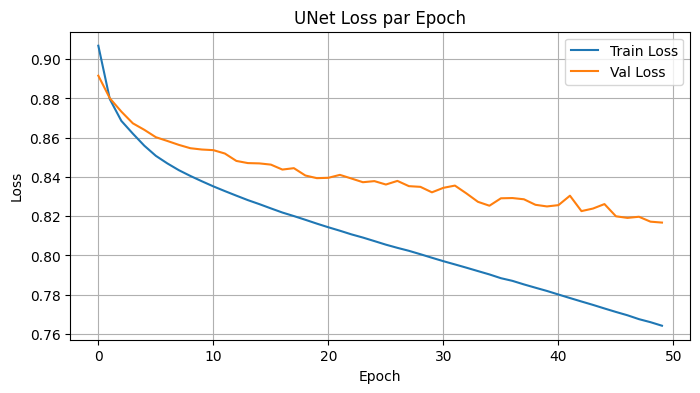

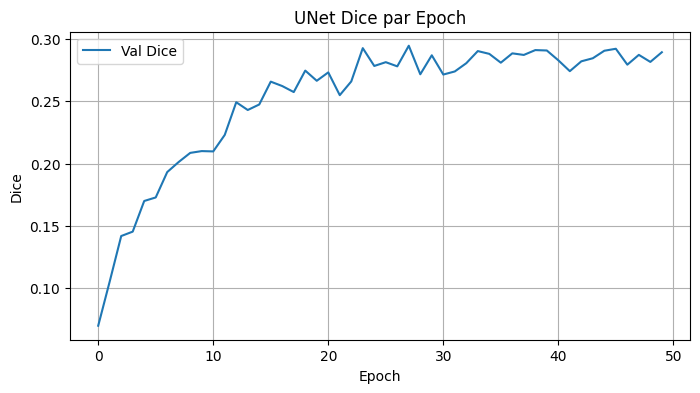

In [ ]:
# =========================
# 3) Fine-tuning UNet
# =========================
# Hyper-paramètres UNet
BATCH_UNET       = 4        # batch size pour le fine-tuning et l’évaluation
LR_UNET_FROZEN   = 1e-5     # learning rate pour les couches gelées de l’encodeur
LR_UNET          = 1e-4     # learning rate pour le reste du réseau
N_EPOCH_UNET     = 50       # nombre d’époques de fine-tuning
PATIENCE_UNET    = 10       # patience d’early-stopping sur validation loss
NUM_WORKERS      = 0        # pour DataLoader dans un notebook
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from monai.losses import FocalTverskyLoss
from monai.metrics import DiceMetric

# Gel des 2 premiers niveaux
for p in unet.model[0].conv.unit0.conv.parameters():
    p.requires_grad = False
for p in unet.model[1].submodule[0].conv.unit0.conv.parameters():
    p.requires_grad = False

# DataLoaders supervisés
train_loader = DataLoader(train_dataset, batch_size=BATCH_UNET,
    shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_UNET,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_UNET,
    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Loss, optim avec lr différentiel, scheduler, métrique
criterion_unet = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
optimizer_unet = torch.optim.AdamW([
    {'params': filter(lambda x: not x.requires_grad, unet.parameters()), 'lr': LR_UNET_FROZEN},
    {'params': filter(lambda x:   x.requires_grad, unet.parameters()), 'lr': LR_UNET},
], weight_decay=1e-5)
scheduler_unet = ReduceLROnPlateau(optimizer_unet, mode="min", patience=5, factor=0.5, verbose=True)
dice_metric    = DiceMetric(include_background=False, reduction="mean")

# Boucle fine-tuning
best_val, es = float("inf"), 0
hist = {'train_loss':[], 'val_loss':[], 'val_dice':[]}

for ep in range(1, N_EPOCH_UNET+1):
    # Train
    unet.train(); rt=0
    for imgs, msk, _ in tqdm(train_loader, desc=f"FT Train {ep}"):
        imgs, msk = imgs.to(DEVICE), msk.to(DEVICE)
        log = unet(imgs)
        l   = criterion_unet(log, msk)
        optimizer_unet.zero_grad(); l.backward(); optimizer_unet.step()
        rt += l.item()
    hist['train_loss'].append(rt/len(train_loader))

    # Val
    unet.eval(); dm=DiceMetric(include_background=False,reduction='mean'); rv=0
    with torch.no_grad():
        for imgs, msk, _ in tqdm(val_loader, desc=f"FT Val {ep}"):
            imgs, msk = imgs.to(DEVICE), msk.to(DEVICE)
            log = unet(imgs)
            rv += criterion_unet(log, msk).item()
            pr = (torch.sigmoid(log)>0.5).float()
            dm(y_pred=pr, y=msk)
    hist['val_loss'].append(rv/len(val_loader))
    hist['val_dice'].append(dm.aggregate().item())

    scheduler_unet.step(hist['val_loss'][-1])
    if hist['val_loss'][-1] < best_val:
        best_val, es = hist['val_loss'][-1], 0
        torch.save(unet.state_dict(), os.path.join(MODEL_DIR,"best_unet_ft.pth"))
    else:
        es += 1
        if es>=PATIENCE_UNET: break


# Affichage des courbes FT
plt.figure(figsize=(8,4))
plt.plot(hist['train_loss'], label="Train FT")
plt.plot(hist['val_loss'],   label="Val FT")
plt.legend(); plt.title("FT Loss"); plt.show()
plt.figure(figsize=(8,4))
plt.plot(hist['val_dice'],label="Val Dice"); plt.title("FT Dice"); plt.show()


## Evaluate with test dataset

Test inference:   0%|          | 0/26 [00:00<?, ?it/s]

Test inference: 100%|██████████| 26/26 [00:04<00:00,  5.29it/s]


🎯 Dice moyen sur le test set : 0.0366 (sur 103 slices)


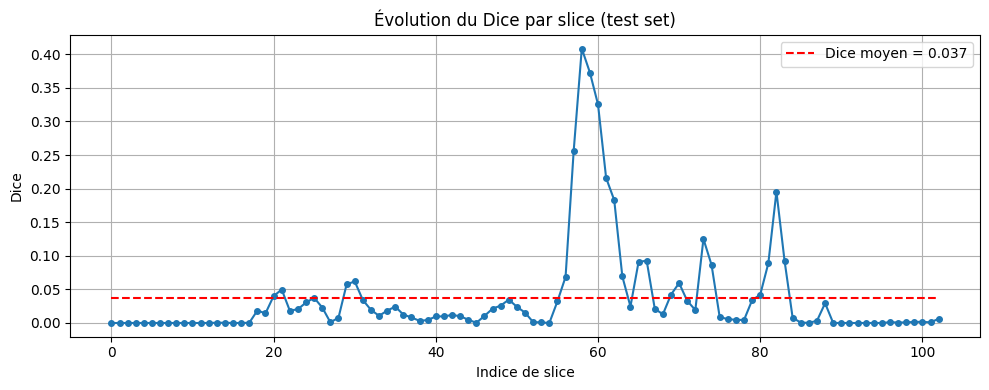

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from monai.metrics import DiceMetric
from tqdm import tqdm

# 1) Préparation du test loader (si pas déjà défini)
BATCH_SIZE_UNET = 4
NUM_WORKERS     = 0

test_loader = DataLoader(
    test_dataset,      # PngSlicesDataset(with_mask=True)
    batch_size=BATCH_SIZE_UNET,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# 2) Passage du modèle en mode éval
unet.eval()

# 3) Boucle d’inférence et calcul du Dice par slice
dice_per_slice = []
slice_indices  = []  # pour garder l’indice global de slice
global_idx     = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test inference"):
        imgs, masks, _ = batch
        imgs, masks = imgs.cuda(), masks.cuda()
        logits = unet(imgs)
        preds  = (torch.sigmoid(logits) > 0.5).float()

        # Pour chaque image du batch, on calcule un Dice slice
        for b in range(preds.shape[0]):
            pred_b = preds[b,0]
            mask_b = masks[b,0]
            # Dice = 2 * |A ∩ B| / (|A| + |B|)  (évite MONAI ici pour la clarté)
            inter = (pred_b * mask_b).sum().item()
            union = pred_b.sum().item() + mask_b.sum().item()
            dice  = (2 * inter / union) if union > 0 else 1.0  # si masque vide, Dice=1
            dice_per_slice.append(dice)
            slice_indices.append(global_idx)
            global_idx += 1

# 4) Affichage du score moyen
mean_dice = np.mean(dice_per_slice)
print(f"🎯 Dice moyen sur le test set : {mean_dice:.4f} (sur {len(dice_per_slice)} slices)")

# 5) Tracé de l’évolution du Dice slice par slice
plt.figure(figsize=(10,4))
plt.plot(slice_indices, dice_per_slice, marker='o', linestyle='-', markersize=4)
plt.hlines(mean_dice, slice_indices[0], slice_indices[-1], colors='r', linestyles='dashed', label=f"Dice moyen = {mean_dice:.3f}")
plt.title("Évolution du Dice par slice (test set)")
plt.xlabel("Indice de slice")
plt.ylabel("Dice")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🔎 Test loader: 26 batches x 4 images


Eval batches: 100%|██████████| 26/26 [00:04<00:00,  5.55it/s]


🎯 Dice moyen sur le jeu de test : 0.0424


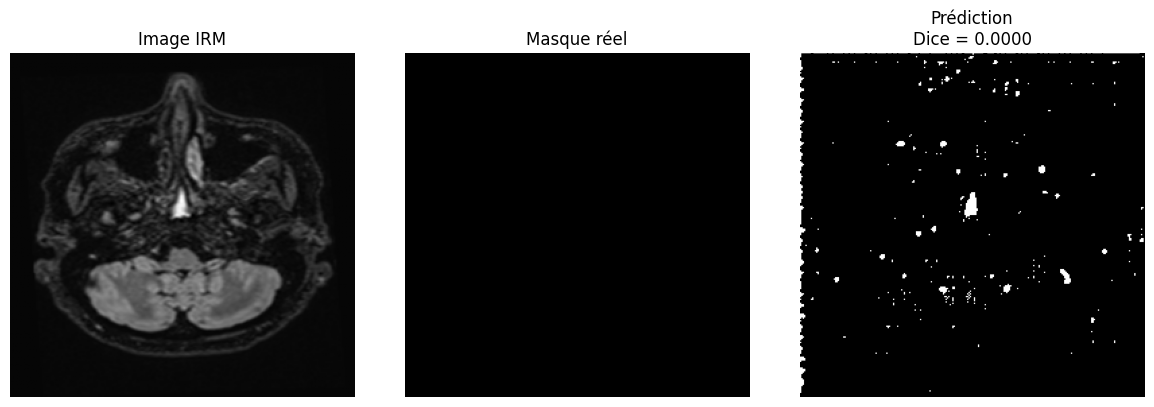

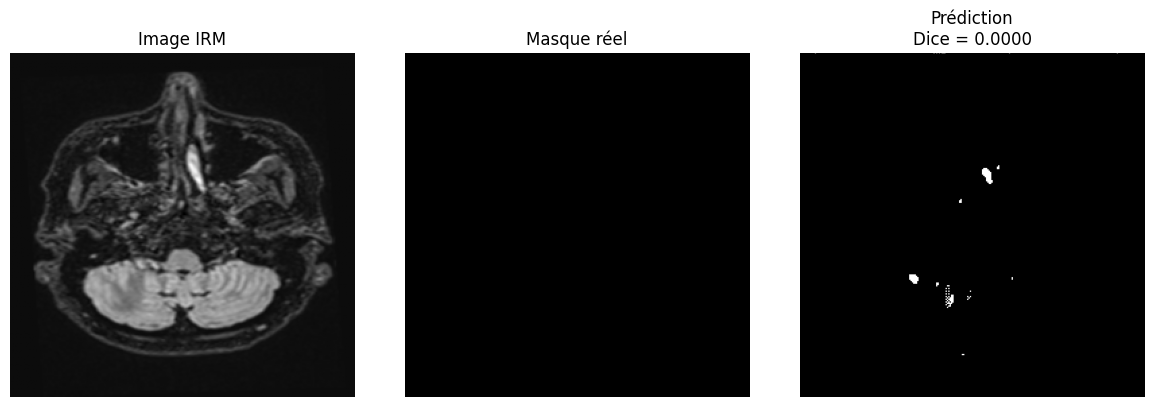

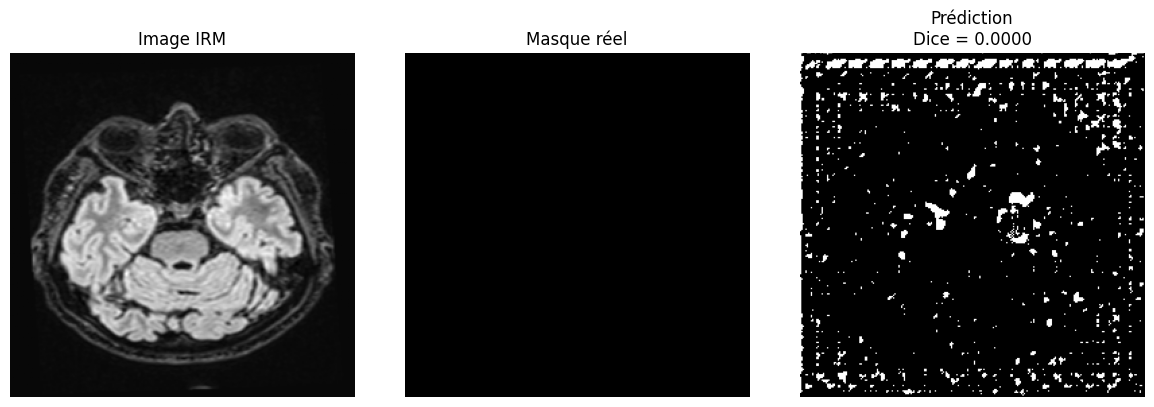

In [14]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from monai.metrics import DiceMetric
from tqdm import tqdm    # ← import standard tqdm
import random

# -------------------------
# Config
# -------------------------
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE_UNET = 4
NUM_WORKERS     = 0

# (Re)définition du test_loader si besoin
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE_UNET,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print(f"🔎 Test loader: {len(test_loader)} batches x {BATCH_SIZE_UNET} images")

# -------------------------
# Évaluation sur tout le jeu de test
# -------------------------
unet.eval()
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric.reset()

with torch.no_grad():
    for imgs, masks, _ in tqdm(test_loader, desc="Eval batches"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = unet(imgs)
        preds  = (torch.sigmoid(logits) > 0.5).float()
        dice_metric(y_pred=preds, y=masks)

test_dice = dice_metric.aggregate().item()
print(f"🎯 Dice moyen sur le jeu de test : {test_dice:.4f}")

# -------------------------
# Fonction de visualisation d’un slice aléatoire
# -------------------------
def show_random_slices(n_slices=3):
    # Récupération de toutes les images et masques
    imgs_all, masks_all = [], []
    with torch.no_grad():
        for imgs, masks, _ in test_loader:
            imgs_all.append(imgs)
            masks_all.append(masks)
    imgs_all = torch.cat(imgs_all, dim=0)
    masks_all = torch.cat(masks_all, dim=0)

    total = imgs_all.shape[0]
    indices = random.sample(range(total), k=min(n_slices, total))

    for idx in indices:
        img = imgs_all[idx:idx+1].to(DEVICE)
        mask = masks_all[idx:idx+1].to(DEVICE)
        with torch.no_grad():
            pred = (torch.sigmoid(unet(img)) > 0.5).float()
        # Dice slice
        dice_metric.reset()
        dice_metric(y_pred=pred, y=mask)
        sc = dice_metric.aggregate().item()

        # Passage en numpy pour affichage
        img_np  = img.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_np = pred.cpu().squeeze().numpy()

        # Affichage
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img_np,  cmap="gray")
        axes[0].set_title("Image IRM")
        axes[1].imshow(mask_np, cmap="gray")
        axes[1].set_title("Masque réel")
        axes[2].imshow(pred_np, cmap="gray")
        axes[2].set_title(f"Prédiction\nDice = {sc:.4f}")
        for ax in axes:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

# Affiche 3 slices aléatoires
show_random_slices(n_slices=3)
